# **Asignatura de Big Data Analytics**

Antonio Gómez Giménez

i72gogia@uco.es

---

# **Preparar entorno**

En primer lugar, debemos instalar todas las dependencias necesarias para poder ejecutar el algoritmo. Así, tenemos que instalar Java 8, Spark 3.0 con Hadoop 3.2, y findspark para alojar spark en el sistema (acceder a Spark desde un Notebook).

In [ ]:
# Instalacion de java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Instalacion de spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# Descomprimimos el fichero de spark
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# Instalamos findspark
!pip install -q findspark

# Establecemos las variables de entorno para Java y Spark 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# **Prueba dataset Zoo con Arbol de decisión**

Ejecutamos una sesion local de spark para comprobar que esta funcionando.

In [55]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Importamos el conjunto de datos con el que queremos trabajar y comprobamos que se ha subido correctamente

In [56]:
from google.colab import files
uploaded = files.upload()

!ls

Saving zoo.csv to zoo (3).csv
 sample_data			'zoo (1).csv'   zoo.csv
 spark-3.0.0-bin-hadoop3.2	'zoo (2).csv'
 spark-3.0.0-bin-hadoop3.2.tgz	'zoo (3).csv'


Leemos el dataset con el que queremos trabajar, en este caso vamos a trabajar con el dataset de Zoo



In [57]:
dataset = spark.read.csv('zoo.csv',inferSchema=True, header =True)

Mostramos los atributos que tiene el dataset y su tipo

In [58]:
dataset.printSchema()

root
 |-- animal_name: string (nullable = true)
 |-- hair: integer (nullable = true)
 |-- feathers: integer (nullable = true)
 |-- eggs: integer (nullable = true)
 |-- milk: integer (nullable = true)
 |-- airborne: integer (nullable = true)
 |-- aquatic: integer (nullable = true)
 |-- predator: integer (nullable = true)
 |-- toothed: integer (nullable = true)
 |-- backbone: integer (nullable = true)
 |-- breathes: integer (nullable = true)
 |-- venomous: integer (nullable = true)
 |-- fins: integer (nullable = true)
 |-- legs: integer (nullable = true)
 |-- tail: integer (nullable = true)
 |-- domestic: integer (nullable = true)
 |-- catsize: integer (nullable = true)
 |-- class_type: integer (nullable = true)



Ahora vamos a trabajar con todas las variables y la varible variety será la salida. Creamos un conjunto de datos donde los inputs serán un vector

In [59]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

df = VectorAssembler(inputCols=['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 
                                'fins', 'legs', 'tail', 'domestic', 'catsize'], 
                     outputCol = 'inputs').transform(dataset)

df = df.select(['inputs','class_type'])

df.printSchema()

labelIndexer = StringIndexer(inputCol='class_type', outputCol='Class').fit(df)
df = labelIndexer.transform(df)

root
 |-- inputs: vector (nullable = true)
 |-- class_type: integer (nullable = true)



Dividimos el conjunto de datos en train y test. Vamos a considerar una partición del tipo 80/20

In [60]:
trainData,testData = df.randomSplit([0.8,0.2])

Indicamos qué atributos serán las entradas y cuales serán la salida. Finalmente, entrenamos y testeamos con trainData y testData, y mostramos las predicciones

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'inputs', labelCol = 'Class', maxDepth = 3)

#Entrenamos el modelo con el conjunto de train
model = dt.fit(trainData)

#Hacemos predicciones
predictions = model.transform(testData)

#Mostramos las predicciones
predictions.select('Class', 'prediction').show()

+-----+----------+
|Class|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  4.0|       3.0|
|  6.0|       3.0|
|  6.0|       3.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  6.0|       3.0|
|  2.0|       2.0|
|  2.0|       2.0|
+-----+----------+
only showing top 20 rows



Mostramos resultados del modelo en test

Test Error = 0.217391
Accuracy = 0.782609 


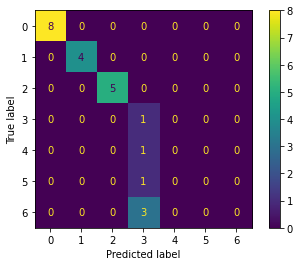

In [64]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("Class").collect()

cm = confusion_matrix(y_orig, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

Mostramos el arbol resultado del modelo

In [65]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_80646c6ddbc5, depth=3, numNodes=7, numClasses=7, numFeatures=16
  If (feature 3 <= 0.5)
   If (feature 1 <= 0.5)
    If (feature 11 <= 0.5)
     Predict: 3.0
    Else (feature 11 > 0.5)
     Predict: 2.0
   Else (feature 1 > 0.5)
    Predict: 1.0
  Else (feature 3 > 0.5)
   Predict: 0.0



# **Prueba dataset Zoo con Red Neuronal**

Ejecutamos una sesion local de spark para comprobar que esta funcionando.

In [66]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Importamos el conjunto de datos con el que queremos trabajar y comprobamos que se ha subido correctamente

In [67]:
from google.colab import files
uploaded = files.upload()

!ls

Saving zoo.csv to zoo (4).csv
 sample_data			'zoo (1).csv'  'zoo (4).csv'
 spark-3.0.0-bin-hadoop3.2	'zoo (2).csv'   zoo.csv
 spark-3.0.0-bin-hadoop3.2.tgz	'zoo (3).csv'


Leemos el dataset con el que queremos trabajar, en este caso vamos a trabajar con el dataset de zoo




In [68]:
dataset = spark.read.csv('zoo.csv',inferSchema=True, header =True)

Mostramos los atributos que tiene el dataset y su tipo

In [69]:
dataset.printSchema()

root
 |-- animal_name: string (nullable = true)
 |-- hair: integer (nullable = true)
 |-- feathers: integer (nullable = true)
 |-- eggs: integer (nullable = true)
 |-- milk: integer (nullable = true)
 |-- airborne: integer (nullable = true)
 |-- aquatic: integer (nullable = true)
 |-- predator: integer (nullable = true)
 |-- toothed: integer (nullable = true)
 |-- backbone: integer (nullable = true)
 |-- breathes: integer (nullable = true)
 |-- venomous: integer (nullable = true)
 |-- fins: integer (nullable = true)
 |-- legs: integer (nullable = true)
 |-- tail: integer (nullable = true)
 |-- domestic: integer (nullable = true)
 |-- catsize: integer (nullable = true)
 |-- class_type: integer (nullable = true)



Ahora vamos a trabajar con todas las variables y la varible variety será la salida. Creamos un conjunto de datos donde los inputs serán un vector

In [70]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

df = VectorAssembler(inputCols=['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 
                                'fins', 'legs', 'tail', 'domestic', 'catsize'], 
                     outputCol = 'inputs').transform(dataset)

df = df.select(['inputs','class_type'])

df.printSchema()

labelIndexer = StringIndexer(inputCol='class_type', outputCol='Class').fit(df)
df = labelIndexer.transform(df)

root
 |-- inputs: vector (nullable = true)
 |-- class_type: integer (nullable = true)



Dividimos el conjunto de datos en train y test. Vamos a considerar una partición del tipo 80/20

In [71]:
trainData,testData = df.randomSplit([0.8,0.2])

Realizamos el mismo proceso pero para el modelo svm de la libreria mllib.

In [72]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# especificamos las capas de la red neuronal:
# capa de entrada de 16 neuronas (atributos), dos capas intermedias de 5 y 4
# y salida de tamaño 7 (clases posibles)
layers = [16, 5, 4, 7]

dt = MultilayerPerceptronClassifier(featuresCol = 'inputs', labelCol = 'Class', maxIter=100, layers=layers, blockSize=128, seed=1234)

#Entrenamos el modelo con el conjunto de train
model = dt.fit(trainData)

#Hacemos predicciones
predictions = model.transform(testData)

#Mostramos las predicciones
predictions.select('Class', 'prediction').show()

+-----+----------+
|Class|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  4.0|       4.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  3.0|       5.0|
|  5.0|       0.0|
+-----+----------+
only showing top 20 rows



Mostramos resultados del modelo en test

Test Error = 0.130435
Accuracy = 0.869565 


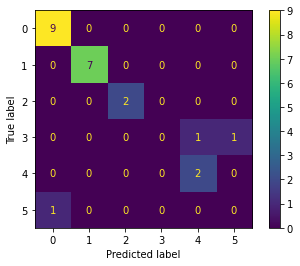

In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("Class").collect()

cm = confusion_matrix(y_orig, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [74]:
spark.stop() 

# **Prueba dataset Zoo con SVM lineal**

Ejecutamos una sesion local de spark para comprobar que esta funcionando.

In [75]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Importamos el conjunto de datos con el que queremos trabajar y comprobamos que se ha subido correctamente

In [76]:
from google.colab import files
uploaded = files.upload()

!ls

Saving zoo.csv to zoo (5).csv
 sample_data			'zoo (1).csv'  'zoo (4).csv'
 spark-3.0.0-bin-hadoop3.2	'zoo (2).csv'  'zoo (5).csv'
 spark-3.0.0-bin-hadoop3.2.tgz	'zoo (3).csv'   zoo.csv


Leemos el dataset con el que queremos trabajar, en este caso vamos a trabajar con el dataset de zoo




In [77]:
dataset = spark.read.csv('zoo.csv',inferSchema=True, header =True)

Mostramos los atributos que tiene el dataset y su tipo

In [78]:
dataset.printSchema()

root
 |-- animal_name: string (nullable = true)
 |-- hair: integer (nullable = true)
 |-- feathers: integer (nullable = true)
 |-- eggs: integer (nullable = true)
 |-- milk: integer (nullable = true)
 |-- airborne: integer (nullable = true)
 |-- aquatic: integer (nullable = true)
 |-- predator: integer (nullable = true)
 |-- toothed: integer (nullable = true)
 |-- backbone: integer (nullable = true)
 |-- breathes: integer (nullable = true)
 |-- venomous: integer (nullable = true)
 |-- fins: integer (nullable = true)
 |-- legs: integer (nullable = true)
 |-- tail: integer (nullable = true)
 |-- domestic: integer (nullable = true)
 |-- catsize: integer (nullable = true)
 |-- class_type: integer (nullable = true)



Ahora vamos a trabajar con todas las variables y la varible variety será la salida. Creamos un conjunto de datos donde los inputs serán un vector

In [79]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

df = VectorAssembler(inputCols=['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 
                                'fins', 'legs', 'tail', 'domestic', 'catsize'], 
                     outputCol = 'features').transform(dataset)

df = df.select(['features','class_type'])

df.printSchema()

labelIndexer = StringIndexer(inputCol='class_type', outputCol='label').fit(df)
df = labelIndexer.transform(df)

root
 |-- features: vector (nullable = true)
 |-- class_type: integer (nullable = true)



Dividimos el conjunto de datos en train y test. Vamos a considerar una partición del tipo 80/20

In [80]:
#tmp
print(df)

DataFrame[features: vector, class_type: int, label: double]


In [81]:
trainData,testData = df.randomSplit([0.8,0.2])

Realizamos el mismo proceso pero para el modelo svm de la libreria mllib.

In [82]:
from pyspark.ml.classification import LinearSVC, OneVsRest, LogisticRegression

#creamos el modelo de svc lineal
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instanciamos the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

#Entrenamos el modelo con el conjunto de train
model = ovr.fit(trainData)

#Hacemos predicciones
predictions = model.transform(testData)

#Mostramos las predicciones
predictions.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  4.0|       4.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
+-----+----------+
only showing top 20 rows



Mostramos resultados del modelo en test

Test Error = 0
Accuracy = 1 


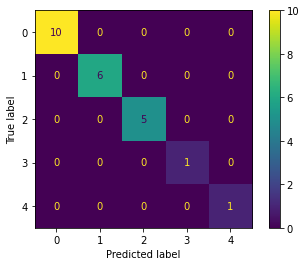

In [83]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [84]:
spark.stop() 

# **Resultados**

\begin{array}{|c|c|} \hline
 & Accuracy & Test Error \\ \hline
Arbol\ de\ decision & 0.782 & 0.217 \\ \hline
Red\ neuronal & 0.869 &  0.130 \\ \hline
SVM\ lineal\ (OVR) & 1 & 0 \\ \hline
\end{array}
<br>
Para la realización de esta práctica se ha escogido el dataset **Zoo**. Este es un dataset para problemas de clasificación. Donde se pretende clasificar distintos animales con su respectiva clase (mamiferos, aves, invertebrados, etc).
Este dataset, es un dataset sencillo con 101 instancias y 16 variables que describen a dicho animal.

Las pruebas realizadas, fueron sobre los modelos de árbol de decisión, red neuronal y svm lineal. En este último, como solo funciona para problemas de clasificación binarios, se le aplicó OVR (One vs Rest), para poder aplicarlo a problemas con distintas clases.

Para este dataset en concreto, si observamos la tabla anterior, podemos apreciar que para clasificar patrones con la estructura del dataset zoo, nos ofrece mejores resultados SVM lineal, ya que la tasa de acierto es de un 100%. El peor clasificador para este caso sería el arbol de decisión. Aun así, probablemente, al crear un nuevo modelo tanto de árbol de decisión como de red neuronal, puede ser que se de el caso contrario, ya que el train y el test se están generando de forma aleatoria.

Cabe destacar, que durante la ejecución del problema se mostraron las matrices de confusión por si se quiere ver, cuales han sido los errores que ha tenido el modelo para cada clase.